# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
spark = SparkSession.builder.appName("AirBnB").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

We will start by loading a spark dataframe, read from .csv files. These files already contain headers, and we allow spark to infer the schema of the data. A spark dataframe is a Resilient Distributed Dataset (RDD) 

In [2]:
# Load listings
listings = spark.read.csv('/data/listings.csv', escape='\"', encoding='ISO-8859-1', header=True, inferSchema=True, multiLine=True, ignoreLeadingWhiteSpace=True, ignoreTrailingWhiteSpace=True)

In [3]:
# Load reviews
reviews = spark.read.csv('/data/reviews.csv', escape='\"', encoding='ISO-8859-1',header=True, inferSchema=True, multiLine=True)

### Describe the data
List the features (schema) and sizes of the datasets.

In [4]:
# Schema of listings
listings.printSchema()

root
 |-- id: string (nullable = true)
 |-- listing_url: string (nullable = true)
 |-- scrape_id: string (nullable = true)
 |-- last_scraped: string (nullable = true)
 |-- name: string (nullable = true)
 |-- summary: string (nullable = true)
 |-- space: string (nullable = true)
 |-- description: string (nullable = true)
 |-- experiences_offered: string (nullable = true)
 |-- neighborhood_overview: string (nullable = true)
 |-- notes: string (nullable = true)
 |-- transit: string (nullable = true)
 |-- access: string (nullable = true)
 |-- interaction: string (nullable = true)
 |-- house_rules: string (nullable = true)
 |-- thumbnail_url: string (nullable = true)
 |-- medium_url: string (nullable = true)
 |-- picture_url: string (nullable = true)
 |-- xl_picture_url: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_url: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- host_location: string (nullable

In [5]:
# Schema of reviews
reviews.printSchema()

root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



In [6]:
# Listings size
print('Nr columns:', len(listings.columns))
print('Nr rows:', listings.count()) 

Nr columns: 106
Nr rows: 1330480


In [7]:
#Reviews size
print('Nr columns:', len(reviews.columns))
print('Nr rows:',reviews.count())

Nr columns: 6
Nr rows: 32297300


Both datasets are quite large, in order to avoid shuffling the data when looking at the size of the dataets we use a sketch that gets the approximate size of the datasets.

In [8]:
# Approximate size of listings based on distinct ids
approx_distinct_listings = listings.select(f.approxCountDistinct('id'))
approx_distinct_listings.show()

+-------------------------+
|approx_count_distinct(id)|
+-------------------------+
|                  1314984|
+-------------------------+



In [9]:
# Approximate size of reviews based on distinct ids
approx_distinct_reviews = reviews.select(f.approxCountDistinct('id'))
approx_distinct_reviews.show()

+-------------------------+
|approx_count_distinct(id)|
+-------------------------+
|                 31920458|
+-------------------------+



### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

##### Cleaning and caching:
Below we clean both dataframes by deciding which columns we want to use for our analysis and drop all rows that have no values in any of the desired columns as well as duplicate rows. As can be seen in the schema of *listings* the data has a lot of column that will be irrelevant for our analysis so we also go ahead and select the columns for each dataframe that apply for later analysis. In order to access our as fast as possible, we use PySparks cache function, to cache the dataframe into memory. This avoids having to re-evaluate the dataframe every single time an action is invoked, which is one of the primary features of Spark's lazy evaluation. 

In [10]:
# Clean listings df
# Drop rows that have missing values in any of the stated columns
listings = listings.dropna(subset=['id', 'name', 'country', 'city', 'neighbourhood', 'property_type', 'price', 'reviews_per_month', 'review_scores_rating', 'number_of_reviews'])

In [11]:
# Drop duplicate rows
listings = listings.drop_duplicates()

In [12]:
# Select relevant columns for analyzing data
listings = listings.select('id', 'name', 'country', 'city', 'neighbourhood', 'property_type', 'price', 'reviews_per_month', 'review_scores_rating', 'number_of_reviews').cache()
listings.show()

+--------+-------------------------------------+--------------+----------------+--------------------+-------------+-------+-----------------+--------------------+-----------------+
|      id|                                 name|       country|            city|       neighbourhood|property_type|  price|reviews_per_month|review_scores_rating|number_of_reviews|
+--------+-------------------------------------+--------------+----------------+--------------------+-------------+-------+-----------------+--------------------+-----------------+
|11979807|                 Appartamento shab...|         Italy|         Firenze|      Centro Storico|    Apartment| $80.00|             0.44|                  86|               18|
|15526491|                 Appartement au ca...|        France|           Paris|   XI Arrondissement|    Apartment| $61.00|             0.12|                  70|                4|
|36061262|                       Depto Coyoacán|        Mexico|Ciudad de México|           Del 

In [13]:
# Clean reviews df
# Drop all rows that contain empty cells
reviews = reviews.dropna()

In [14]:
# Drop duplicate rows
reviews = reviews.drop_duplicates()

In [15]:
# Cache into memory
reviews = reviews.select('listing_id', 'id', 'comments', 'date')
reviews.show()

+----------+---------+--------------------+----------+
|listing_id|       id|            comments|      date|
+----------+---------+--------------------+----------+
|  10000061|204590053|Robyn and Steve’s...|2017-10-19|
|  10000061|235474478|If you’re looking...|2018-02-16|
|  10000061| 71626680|The host canceled...|2016-04-27|
|  10000222|175745558|The host canceled...|2017-07-29|
|   1000039|271348608|Wonderful flat in...|2018-06-01|
|  10000470|192037233|Daniel's place is...|2017-09-09|
|  10001263|275781461|Monica's place is...|2018-06-11|
|  10002239|341869164|It's been years s...|2018-10-28|
|   1000256|163339412|La casetta è ben ...|2017-06-24|
|  10003065|423048826|Tidy place, small...|2019-03-12|
|  10003065|462137657|Robyn and Steve’s...|2019-06-02|
|   1000340|105908776|Pros; Our host wa...|2016-10-03|
|   1000340|287481401|Amazing spot. Fri...|2018-07-08|
|   1000382|  8959167|Beautiful new fla...|2013-11-28|
|  10004378|186608128|Beautiful Trulli ...|2017-08-25|
|  1000524

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [16]:
listings.groupBy('city')\
    .agg(f.count('id'), f.countDistinct('neighbourhood'))\
    .orderBy("count(id)", ascending=False)\
    .show(100, False)

+-------------------+---------+-----------------------------+
|city               |count(id)|count(DISTINCT neighbourhood)|
+-------------------+---------+-----------------------------+
|Paris              |48143    |63                           |
|Greater London     |33229    |149                          |
|London             |25729    |148                          |
|Los Angeles        |22323    |95                           |
|Berlin             |19689    |93                           |
|Roma               |18578    |42                           |
|Toronto            |17874    |140                          |
|København          |17431    |21                           |
|Amsterdam          |16908    |44                           |
|New York           |16157    |91                           |
|Madrid             |15783    |66                           |
|Brooklyn           |15694    |51                           |
|Barcelona          |15525    |68                           |
|Beijing

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

We chose the capital of Sweden, **Stockholm**

In [17]:
stockholm = listings.filter(listings.city == 'Stockholm').cache()
stock_prop = stockholm.groupBy('property_type', 'neighbourhood').agg(f.count('id').alias('ids')).orderBy('neighbourhood')

For plotting purposes, have to transform the spark dataframe into a pandas datafram, with each neighborhood on the x axis and the number of listings on the y.

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


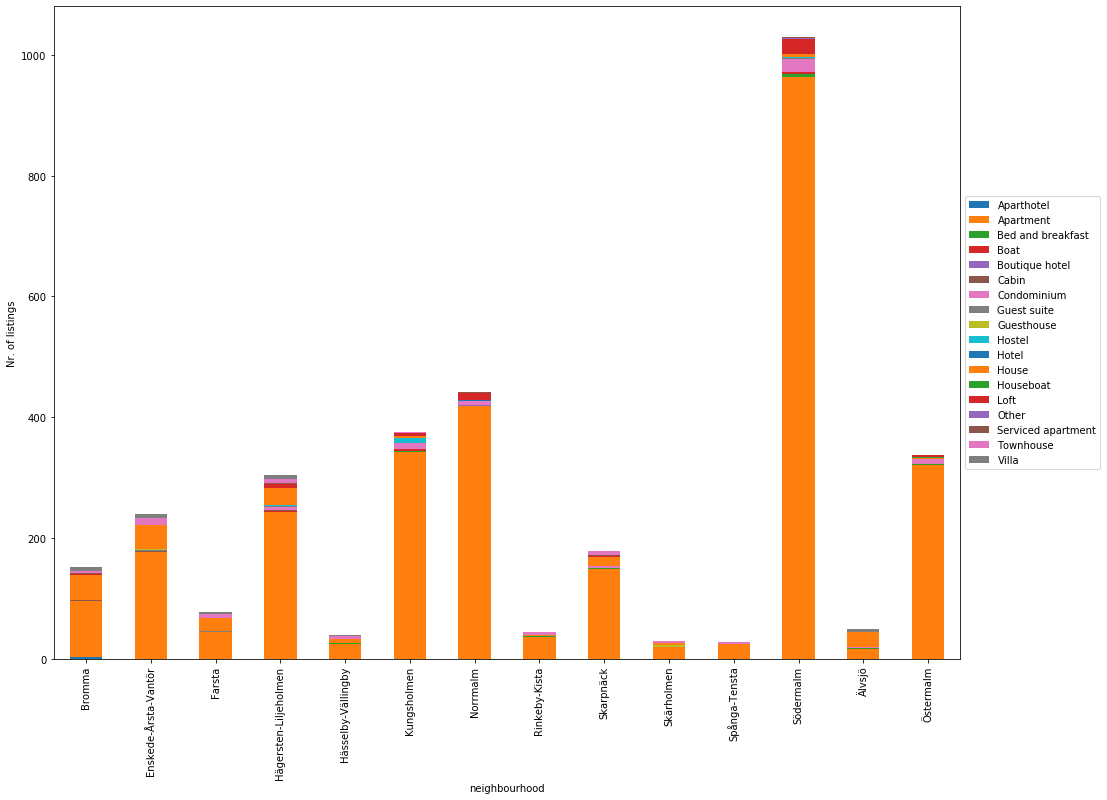

In [18]:
stock_prop  = stock_prop.select("*").toPandas().pivot(index='neighbourhood', columns='property_type', values='ids').plot.bar(stacked=True, figsize=(25,12))
plt.ylabel('Nr. of listings')
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width*0.65, box.height])
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

## Prices
Compute the minimum, maximum and average listing price in your city. 

We will start off by removing the dollar sign in the price column, converting them to non-comma delimited strings, and casting them as floats in order to estimate values.

In [19]:
price = f.udf(lambda x: x.replace(u'$',''))
stockholm = stockholm.withColumn('Price', price('Price'))
stockholm = stockholm.withColumn('Price', f.udf(lambda x: x.replace(u',',''))('Price').cast('float'))
stockholm.show()

+--------+--------------------+-------+---------+--------------------+-------------+------+-----------------+--------------------+-----------------+
|      id|                name|country|     city|       neighbourhood|property_type| Price|reviews_per_month|review_scores_rating|number_of_reviews|
+--------+--------------------+-------+---------+--------------------+-------------+------+-----------------+--------------------+-----------------+
|13862496|Apartment in Vasa...| Sweden|Stockholm|            Norrmalm|    Apartment| 587.0|             0.03|                  80|                1|
|21200081|Location, locatio...| Sweden|Stockholm|           Södermalm|    Apartment| 998.0|             0.17|                 100|                4|
| 6543006|Room in Central S...| Sweden|Stockholm|            Norrmalm|    Apartment| 401.0|             1.47|                  92|               77|
| 6659041|Central charming ...| Sweden|Stockholm|            Norrmalm|    Apartment| 646.0|             0.

In [20]:
stockholm.select(f.min('Price'), f.max('Price'), f.avg('Price')).show()

+----------+----------+----------------+
|min(Price)|max(Price)|      avg(Price)|
+----------+----------+----------------+
|      98.0|   10155.0|1089.82957619477|
+----------+----------+----------------+



Compute and visualize the distribution of listing prices in your city.

We'll plot the distribution of prices of AirBnB's located in the lovely city of Stockholm. 

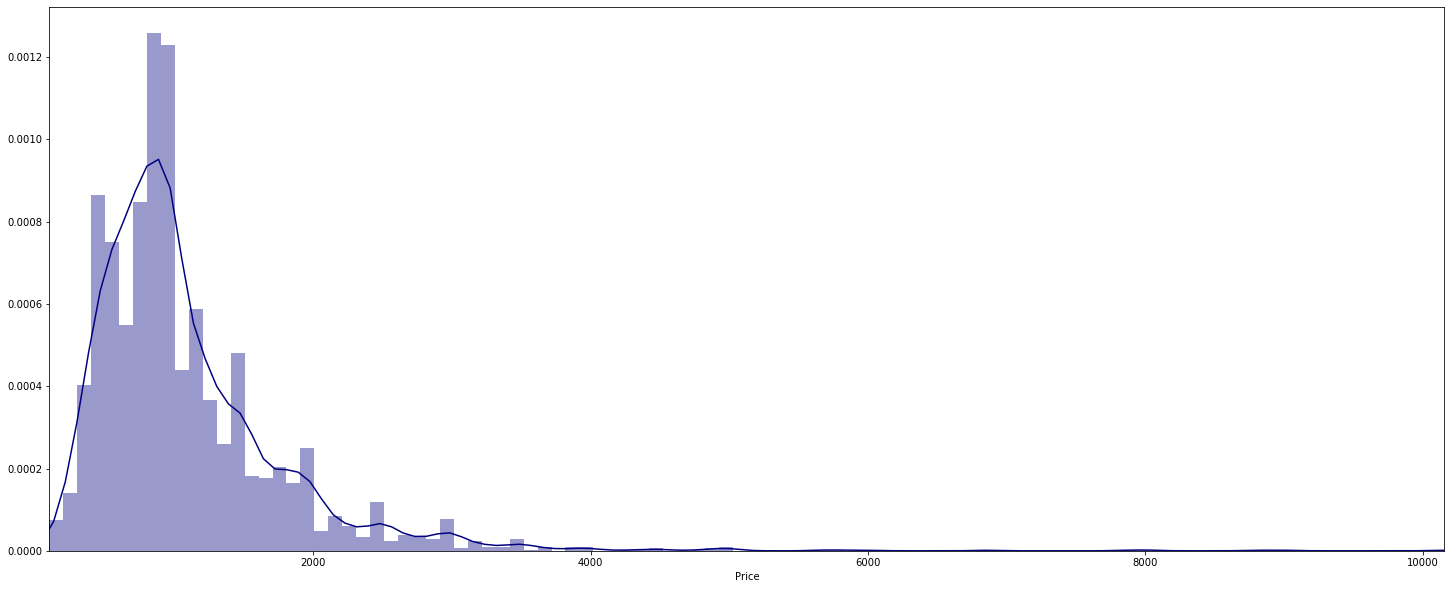

In [21]:
#Create pandas dataframe for plotting purposes
stockholmdf = stockholm.select(stockholm.Price).toPandas()
plt.figure(figsize=(25, 10))
sns.set_palette(sns.light_palette("navy", reverse=True))
p = sns.distplot(stockholmdf['Price'], bins=100)
p= p.set_xlim(min(stockholmdf['Price']), max(stockholmdf['Price']))

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [22]:
values = stockholm.withColumn('value', f.col('review_scores_rating') / f.col('Price')).select('name', 'value', 'neighbourhood', 'review_scores_rating', 'price', 'number_of_reviews')
window = Window.partitionBy(values['neighbourhood']).orderBy(values['value'].desc())
values.select('*', f.rank().over(window).alias('rank')).filter(f.col('rank') <= 3).orderBy('neighbourhood').show()

+--------------------+-------------------+--------------------+--------------------+-----+-----------------+----+
|                name|              value|       neighbourhood|review_scores_rating|price|number_of_reviews|rank|
+--------------------+-------------------+--------------------+--------------------+-----+-----------------+----+
|        Balla Bromma| 0.4444444444444444|              Bromma|                 100|225.0|                3|   2|
| Nice room in Bromma| 0.7948717948717948|              Bromma|                  93|117.0|               23|   1|
|Rent a room in St...|              0.375|              Bromma|                  99|264.0|               26|   3|
|Shared room for F...| 0.6802721088435374|Enskede-Årsta-Vantör|                 100|147.0|                2|   1|
|Cosy 50th style a...| 0.5102040816326531|Enskede-Årsta-Vantör|                 100|196.0|                2|   2|
|Bekväm lägenhet i...|0.47959183673469385|Enskede-Årsta-Vantör|                  94|196.

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

#### Joining and grouping
In order to do this, a join must be conducted between the two dataframes on the listing IDs with an inner join. Since these dataframes are of considerable size, we want to avoid the shuffling conducted by a non-broadcasted joins. We subsequently group the joined dataframe by its month and year, showing us reviews over time.

In [23]:
#Joining
#stockholm_rv = stockholm.join(reviews, stockholm.id == reviews.listing_id, 'inner').select(reviews.comments, stockholm.review_scores_rating).toPandas()
popularity = stockholm.join(reviews, stockholm.id == reviews.listing_id, 'inner').select(stockholm.id, stockholm.neighbourhood, reviews.date)#('id','neighbourhood').join(reviews.select('listing_id','date'),(f.col('id') == f.col('listing_id')) , 'inner')

In [24]:
#Grouping by month & neighborhood (for subsequent analysis)
popularity = popularity.withColumn('month',
              popularity['date'].substr(0, 7)
     ).groupby('month','neighbourhood')\
      .agg(f.count('id').alias('nr_reviews')).orderBy('month')

In [25]:
def plot_month(season=False):
    plt.figure(figsize=(25, 10))
    if season:
        #Grouping again by month, disregarding year
        df= popularity.withColumn('month',
              popularity['month'].substr(6,7)
     ).groupby('month')\
      .agg(f.sum('nr_reviews')).orderBy('month')
    else:
        #Grouping again by monthly total analysis
        df = popularity.groupBy('month').agg(f.sum('nr_reviews')).orderBy('month')
    sns.set_palette(sns.light_palette("navy", reverse=True))
    p = sns.barplot(x='month', y='sum(nr_reviews)', data =df.toPandas())
    x = p.set_xticklabels(p.get_xticklabels(),rotation=45)
    return p

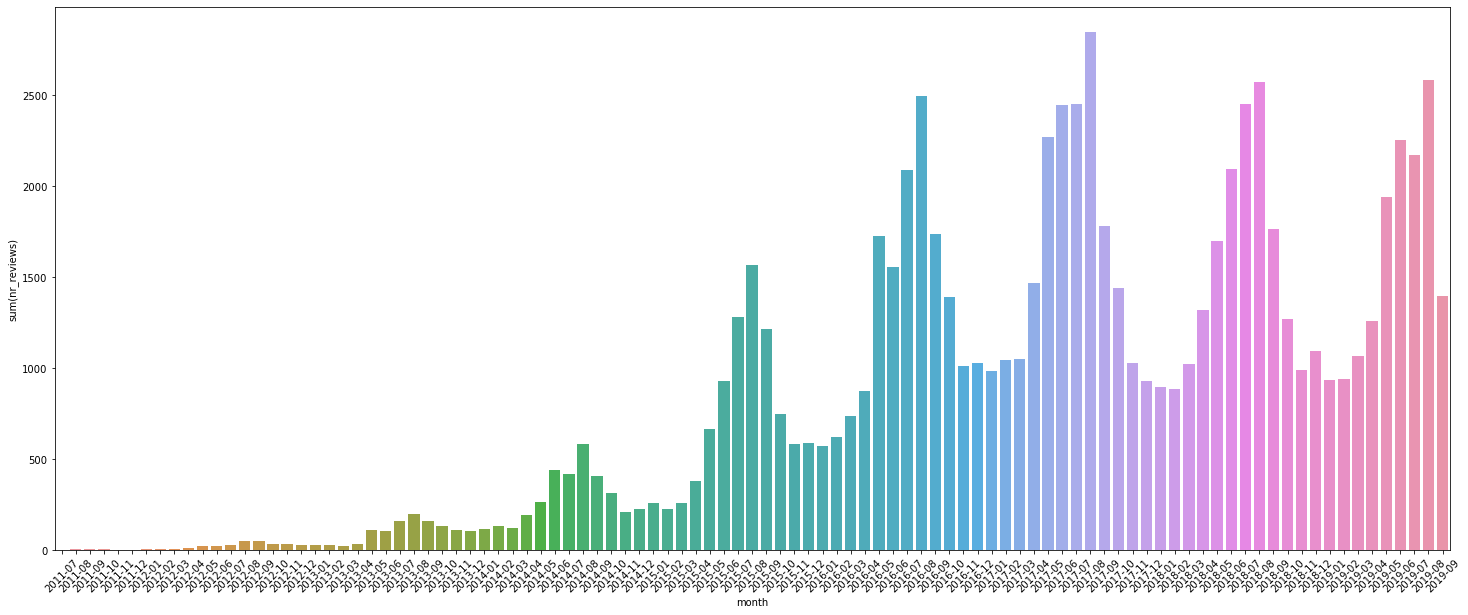

In [26]:
plot_month()

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [27]:
def plot_neighborhood(neighborhood):
    plt.figure(figsize=(25, 10))
    sns.set_palette(sns.light_palette("navy", reverse=True))
    p = sns.barplot(x='month', y='nr_reviews', data =popularity.filter(f.col('neighbourhood')==neighborhood).toPandas())
    x = p.set_xticklabels(p.get_xticklabels(),rotation=45)
    return p

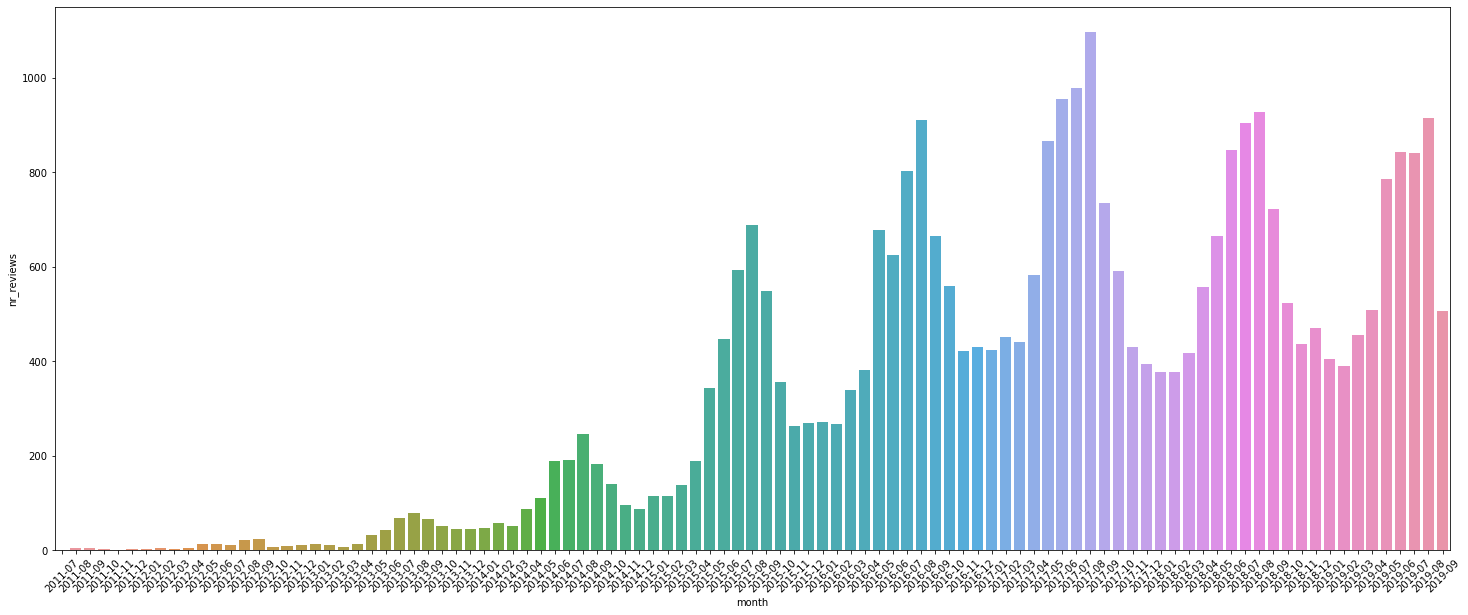

In [28]:
plot_neighborhood('Södermalm')

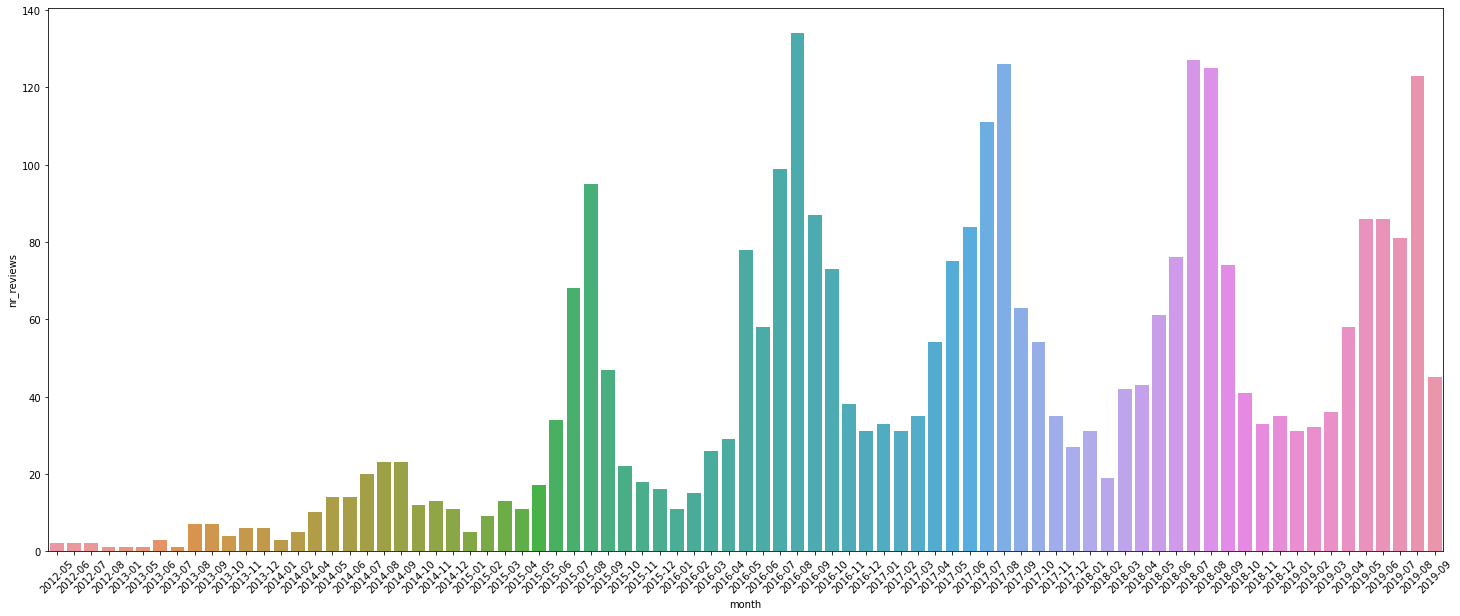

In [29]:
plot_neighborhood('Skarpnäck')

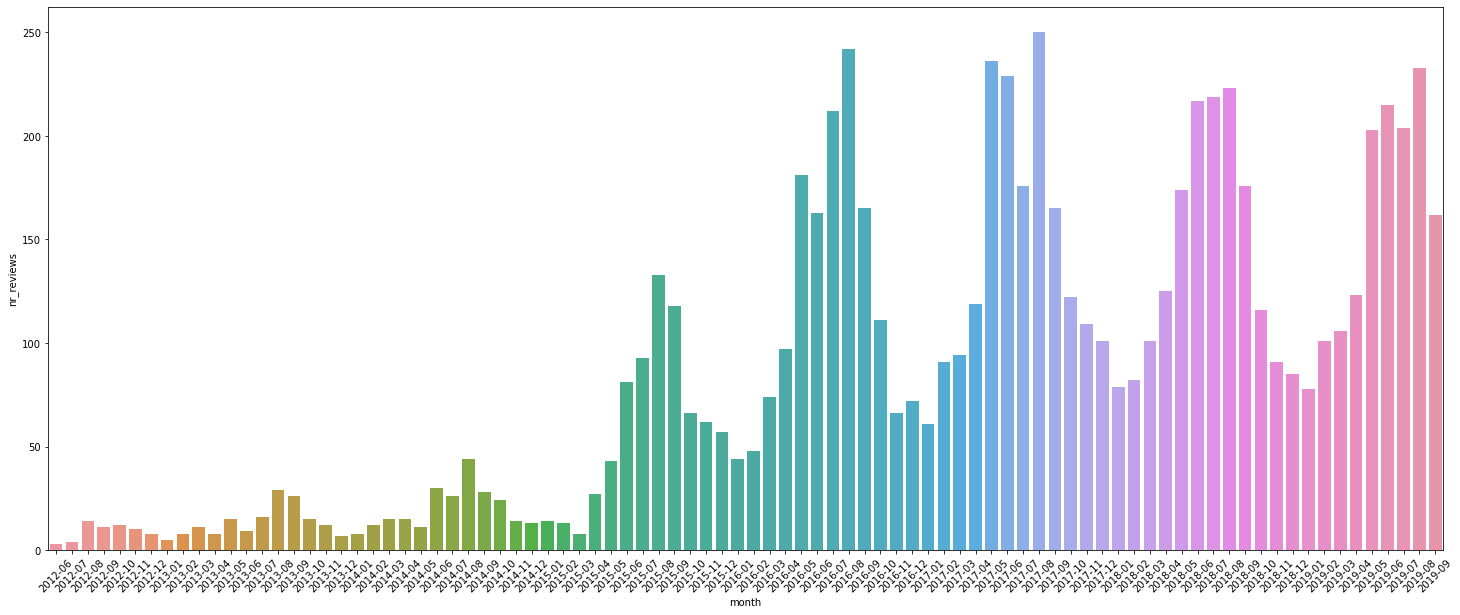

In [30]:
plot_neighborhood('Östermalm')

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

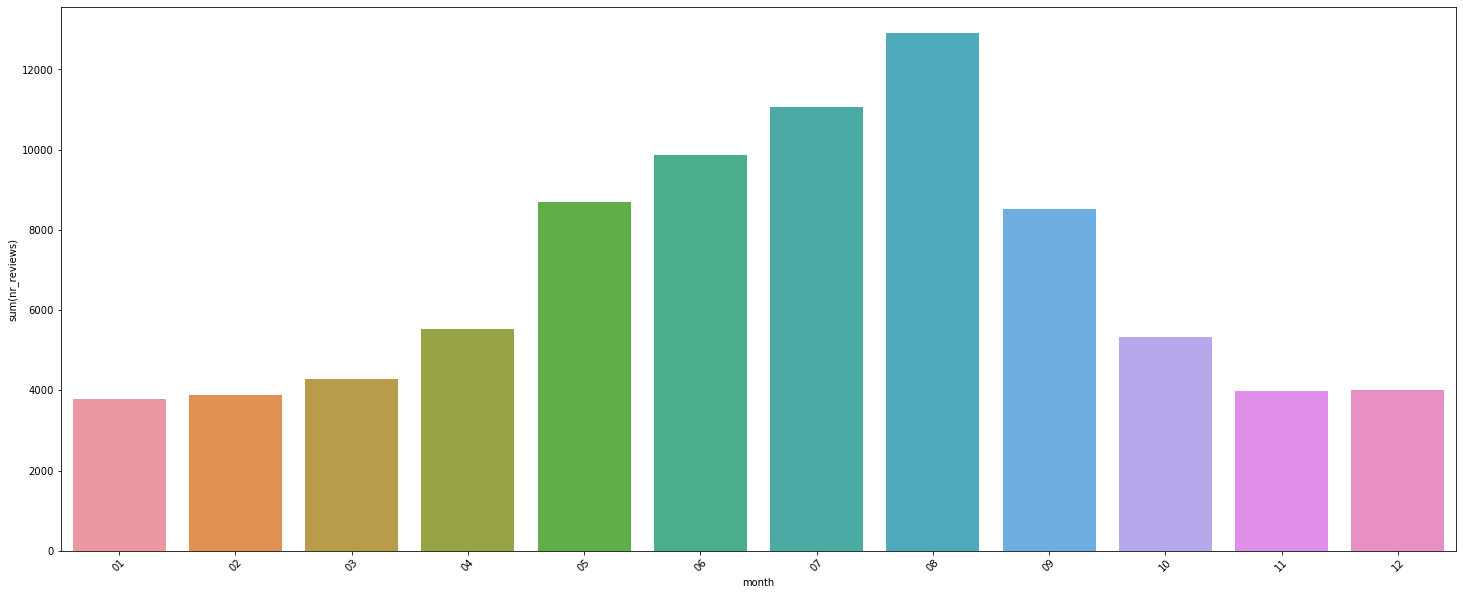

In [31]:
plot_month(season=True)

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

We load a text file from github with positive words originally used for sentiment analysis. The appearance of an positive word in a sentence does not necessarily mean it is a positive review though. We rate the positivity of the words by counting how often they occur in the reviews and sum up the scores of the reviews the word appears in. Then to give the word a final rating we take the ratio between the score and occurrences. That way we can almost make sure these words are associated with a positive review. Note that these words are *strictly in English* and another sentiment analysis file must be used for other languages.
We then create a function that takes in a dataframe that you would like to review. The function creates an empty dictionary and loops through every word of the review. If a word can be found in the positive text file, it gets added to the dictionary if it is not already there and gets the occurrence value of 1. If it the word is already present in the dictionary, its occurrence value becomes 1 greater and the score gets higher. We then sort the dataframe by the number of occurrences and then the score and finally the rating of the word. 

In [32]:
positive = pd.read_table('https://gist.githubusercontent.com/mkulakowski2/4289437/raw/1bb4d7f9ee82150f339f09b5b1a0e6823d633958/positive-words.txt',skiprows=36, header=None, names=['words'])

In [33]:
def positive_words(df):
    word_dict = dict()
    for index, row in df.iterrows():
        for word in row['comments'].split():
            if not word.isalpha():
                word = ''.join(c for c in word if c.isalpha())
            word = word.lower()
            if word not in word_dict and word in positive['words'].values:
                word_dict[word] = {'occurrences': 1, 'score': pd.to_numeric(row['review_scores_rating'])}
            elif word in word_dict:
                word_dict[word]['occurrences'] += 1
                word_dict[word]['score'] += pd.to_numeric(row['review_scores_rating'])
    return word_dict

In [34]:
# Load in the data we want to use 
stockholm_rv = stockholm.join(reviews, stockholm.id == reviews.listing_id, 'inner').select(reviews.comments, stockholm.review_scores_rating).toPandas()

In [35]:
word_dict = positive_words(stockholm_rv)

In [36]:
word_df = pd.DataFrame(word_dict).T
word_df['rating'] = word_df.apply(lambda row: row['score'] / row['occurrences'], axis=1)
word_df.sort_values(by=['occurrences', 'score','rating'], ascending=False).head(30)

,occurrences,score,rating
great,35128,3355398,95.519187
nice,25157,2391310,95.055452
clean,19083,1821582,95.455746
recommend,15880,1521033,95.782935
good,14307,1353461,94.601314
perfect,12939,1239709,95.811809
easy,12326,1175536,95.370436
well,12299,1174152,95.467274
comfortable,11495,1099356,95.637756
helpful,9768,933233,95.539824
